In [ ]:
# Student ID: 1006842543
# Student Name: Sheng Zhang
# Student Email: eily.zhang@mail.utoronto.ca
# Instructor: Professor Shion Guha
# Course Code: INF2178
# Course Name: Experimental Design for Data Science
# Program: MI
# Faculty of Information
# University of Toronto

In [ ]:
# Load the libraries to use in this assignment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
%pip install bioinfokit
from bioinfokit.analys import stat
from statsmodels.graphics.factorplots import interaction_plot
from scipy.stats import shapiro, levene
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

# Show the dataframe
df = pd.read_excel("INF2178_A2_data.xlsx", sheet_name="ChildCareCentres")
df.head()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bioinfokit: filename=bioinfokit-2.1.3-py3-none-any.whl size=59056 sha256=7ae4ff5cb6c3139e8ea20eeef255d90a1a056a8e4f11e6eb1e0cd5338b7f206a
  Stored in directory: /root/.cache/pip/wheels/ac/67/a7/4e0b4172d5415933127e819d7d7080ae08a6220949ad2f6de5
Successfully built bioinfokit


,_id,LOC_ID,LOC_NAME,AUSPICE,ADDRESS,PCODE,ward,bldg_type,BLDGNAME,IGSPACE,TGSPACE,PGSPACE,KGSPACE,SGSPACE,TOTSPACE,subsidy,cwelcc_flag
0,1,1013,Lakeshore Community Child Care Centre,Non Profit Agency,101 SEVENTH ST,M8V 3B5,3,Public Elementary School,Seventh Street Public School,0,20,32,52,60,164,Y,Y
1,2,1014,Alternative Primary School Parent Group,Non Profit Agency,1100 SPADINA RD,M5N 2M6,8,Public Elementary School,North Preparatory Public School,0,0,12,26,45,83,Y,Y
2,3,1015,Cardinal Leger Child Care Centre (Scarborough),Non Profit Agency,600 MORRISH RD,M1C 4Y1,25,Catholic Elementary School,Cardinal Leger Catholic School,0,10,16,26,50,102,Y,Y
3,4,1016,George Brown - Richmond Adelaide Childcare Centre,Non Profit Agency,130 ADELAIDE ST W,M5H 3P5,10,Other,NaN,10,15,40,0,0,65,Y,Y
4,5,1017,Woodland Nursery School (Warden Woods Communit...,Non Profit Agency,1 FIRVALLEY CRT,M1L 1N8,20,High Rise Apartment,NaN,0,10,16,0,0,26,Y,Y


In [ ]:
# Only keep the columns that we are interested in
columns_to_keep = ["AUSPICE", "ward", "IGSPACE", "TGSPACE", "PGSPACE", "KGSPACE", "SGSPACE", "TOTSPACE"]
df_new = df[columns_to_keep].copy()

# Create a new column "TotalSpace" that is the sum from "IGSPACE" all the way to "TOTSPACE"
# We are only going to study this new column
df_new["TotalSpace"] = df_new.loc[:, "IGSPACE":"TOTSPACE"].sum(axis=1)
data = df_new[["AUSPICE", "ward", "TotalSpace"]].copy()
data.rename(columns={"AUSPICE": "Auspice_Type", "ward": "Ward_Code", "TotalSpace": "Total_Capacity_Number"}, inplace=True)
data

,Auspice_Type,Ward_Code,Total_Capacity_Number
0,Non Profit Agency,3,328
1,Non Profit Agency,8,166
2,Non Profit Agency,25,204
3,Non Profit Agency,10,130
4,Non Profit Agency,20,52
...,...,...,...
1058,Non Profit Agency,6,224
1059,Non Profit Agency,15,120
1060,Non Profit Agency,13,98
1061,Non Profit Agency,8,112


In [ ]:
# Make a summary table for the continuous variable Total Space
# Also add a new row for variance for the purpose of further ANOVA

# Drop the "Ward Code" column as it is not needed (categorical)
data_no_ward = data.drop(columns=["Ward_Code"])
# Calculate summary statistics for "Total Capacity Number" excluding the "Ward Code" column
new_stats = data_no_ward.describe()
# Calculate variance for "Total Capacity Number"
new_variance_row = pd.DataFrame(data_no_ward.var(numeric_only=True), columns=["Total_Capacity_Number"]).T
# Concatenate summary statistics and variance row
new_summary_stats = pd.concat([new_stats, new_variance_row])
# Rename index
new_summary_stats.index = new_summary_stats.index.rename("Summary Statistics for Total Capacity Number")

new_summary_stats

,Total_Capacity_Number
Summary Statistics for Total Capacity Number,
count,1063.000000
mean,151.349012
std,95.633036
min,12.000000
25%,86.000000
50%,124.000000
75%,194.000000
max,804.000000
Total_Capacity_Number,9145.677511


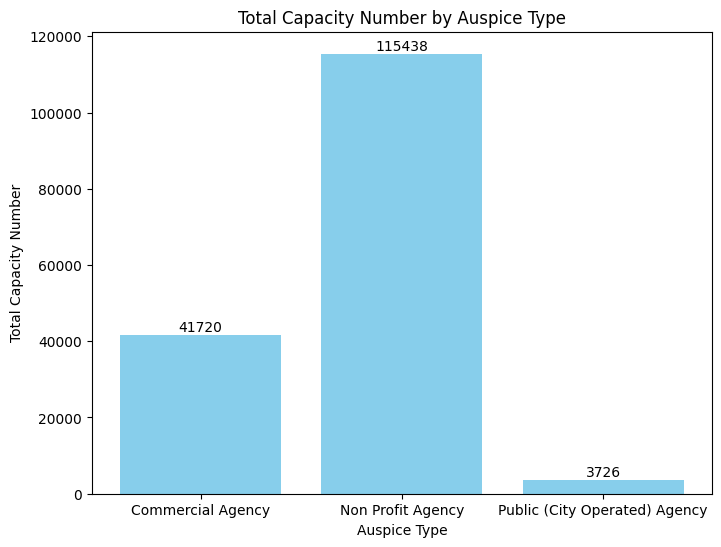

In [ ]:
# Make the bargraph for Total Capacity Number for each Auspice Type

# Aggregate the sum of Total_Capacity_Number for each Auspice_Type
auspice_sum = data.groupby("Auspice_Type")["Total_Capacity_Number"].sum().reset_index()

# Plot the first bar graph: Auspice_Type vs. Total_Capacity_Number sum
plt.figure(figsize=(8, 6))
bars1 = plt.bar(auspice_sum["Auspice_Type"], auspice_sum["Total_Capacity_Number"], color="skyblue")
plt.title("Total Capacity Number by Auspice Type")
plt.xlabel("Auspice Type")
plt.ylabel("Total Capacity Number")

# Add numbers at the top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha="center", va="bottom")

# Show the plot
plt.show()


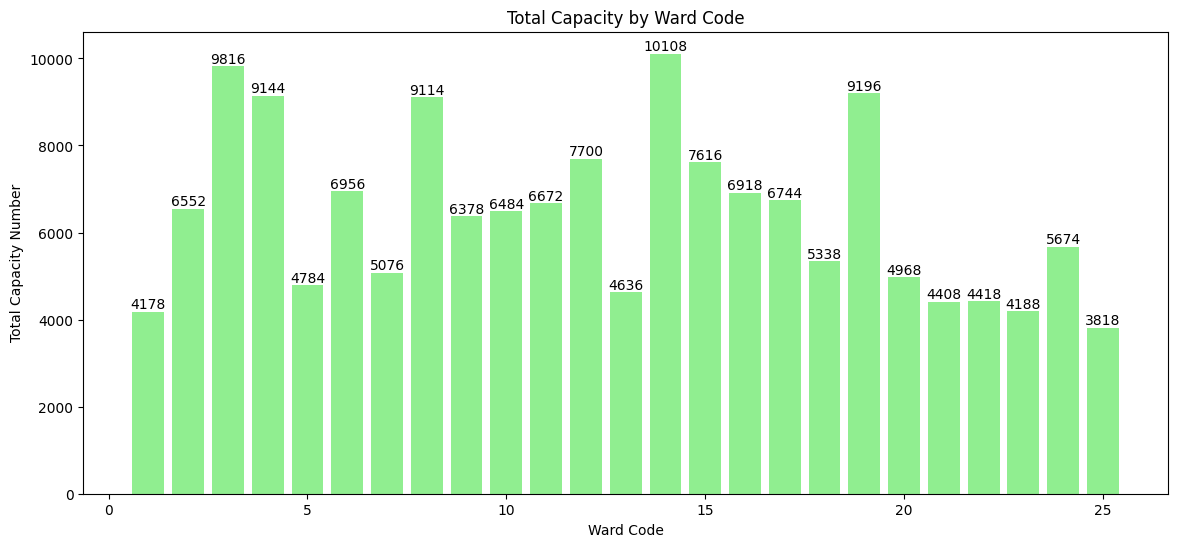

In [ ]:
# Make the bargraph for Total Capacity Number for each Ward Code

# Aggregate the sum of Total_Capacity_Number for each Ward_Code
ward_sum = data.groupby("Ward_Code")["Total_Capacity_Number"].sum().reset_index()

# Plot the bar graph
plt.figure(figsize=(14, 6))
bars2 = plt.bar(ward_sum["Ward_Code"], ward_sum["Total_Capacity_Number"], color="lightgreen")
plt.title("Total Capacity by Ward Code")
plt.xlabel("Ward Code")
plt.ylabel("Total Capacity Number")

# Add numbers at the top of each bar
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha="center", va="bottom")

# Show the plot
plt.show()


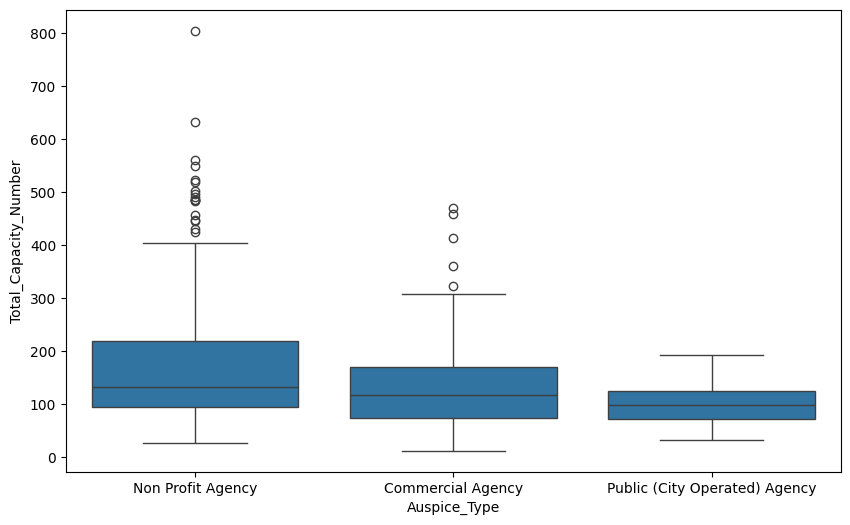

In [ ]:
# Make the boxplot for Total Capcity Number between each auspice type.
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Auspice_Type", y="Total_Capacity_Number", data=data)
plt.show()

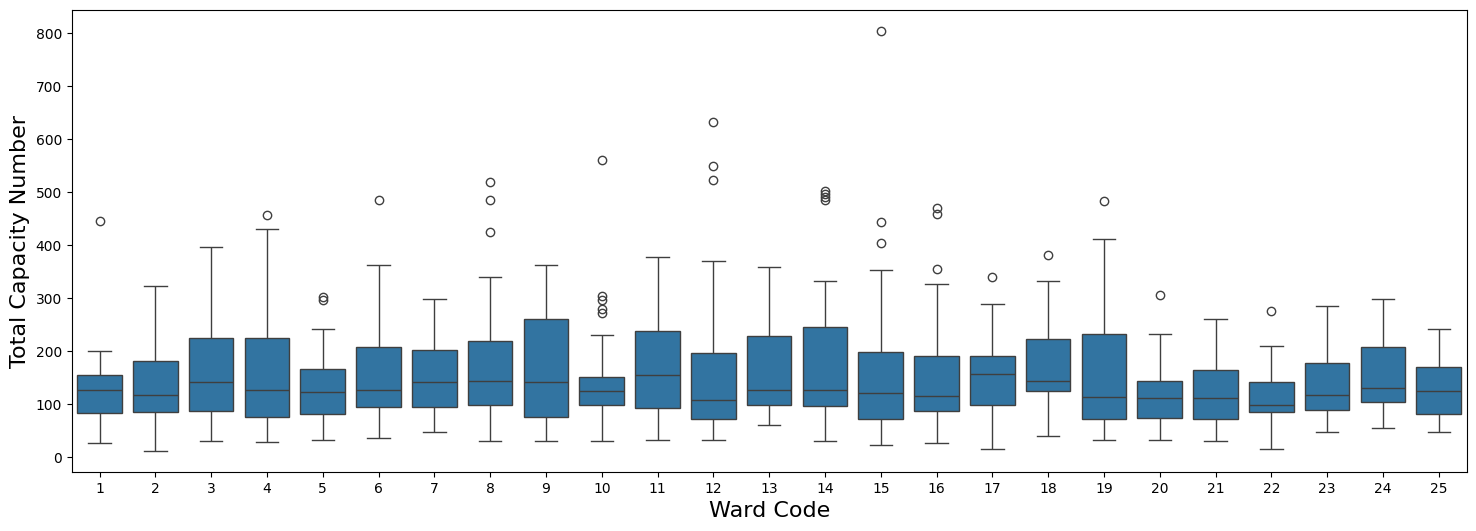

In [ ]:
#Make the boxplot for Total Capcity Number between each ward code
plt.figure(figsize=(18, 6))
ax = sns.boxplot(x="Ward_Code", y="Total_Capacity_Number", data=data)
plt.xlabel("Ward Code", fontsize=16)
plt.ylabel("Total Capacity Number", fontsize=16)
plt.show()


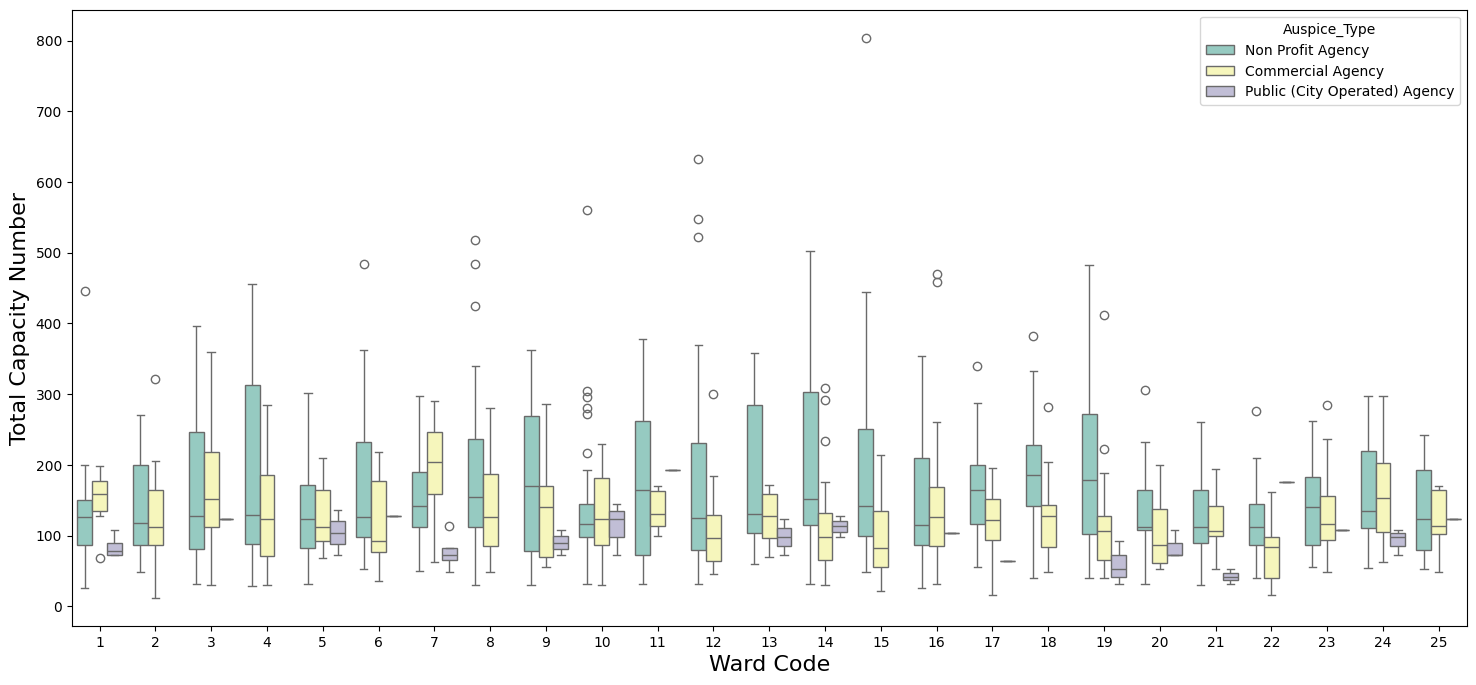

In [ ]:
#Make the boxplot for Total Capcity Number between each ward code AND each auspice type
plt.figure(figsize=(18, 8))
sns.boxplot(x="Ward_Code", y="Total_Capacity_Number", hue="Auspice_Type", data=data, palette="Set3")
plt.xlabel("Ward Code", fontsize=16)
plt.ylabel("Total Capacity Number", fontsize=16)
plt.show()

**One-Way ANOVA for Total Capacity Number between each Auspice Type**

In [ ]:
# Define a function to round the p-value
def round_p_value(p):
    """Round a small p-value so that it is human-readable."""
    if p < 0.001:
        return "<0.001"
    else:
        return f'{p:5.3}'

In [ ]:
# Create the Ordinary Least Squares (OLS) model
model_auspice = ols("Total_Capacity_Number ~ C(Auspice_Type)", data=data).fit()
auspice_anova_table = sm.stats.anova_lm(model_auspice, typ=2)
auspice_anova_table

,sum_sq,df,F,PR(>F)
C(Auspice_Type),3.844485e+05,2.0,21.843051,5.057716e-10
Residual,9.328261e+06,1060.0,NaN,NaN


In [ ]:
# One-way anova table. Round to three decimals and format the p-value
res = stat()
res.anova_stat(df=data, res_var="Total_Capacity_Number", anova_model="Total_Capacity_Number ~ C(Auspice_Type)")
auspice_anova = res.anova_summary
auspice_anova["PR(>F)"] = auspice_anova["PR(>F)"].apply(round_p_value)
auspice_anova_summary = auspice_anova.round(3)
auspice_anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(Auspice_Type),2.0,384448.457,192224.229,21.843,<0.001
Residual,1060.0,9328261.059,8800.246,NaN,nan


In [ ]:
# Apply post hoc test using Tukey's HSD
res = stat()
res.tukey_hsd(df=data, res_var="Total_Capacity_Number", xfac_var="Auspice_Type", anova_model="Total_Capacity_Number ~ C(Auspice_Type)")
auspice_posthoc = res.tukey_summary
# Round the values
auspice_posthoc_summary = auspice_posthoc.round(3)
auspice_posthoc_summary

/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to 

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Non Profit Agency,Commercial Agency,34.239,19.407,49.070,7.662,0.001
1,Non Profit Agency,Public (City Operated) Agency,68.669,32.448,104.890,6.293,0.001
2,Commercial Agency,Public (City Operated) Agency,34.430,-2.906,71.767,3.061,0.078


In [ ]:
# Assumption 1: residuals are normally distributed: Shapiro Wilk test
# Perform Shapiro Wilk test
shapiro_test_auspice_anova = shapiro(model_auspice.resid)
st_auspice_anova_p_value = shapiro_test_auspice_anova.pvalue
# Round the p-value
st_auspice_rounded_p_value = round_p_value(st_auspice_anova_p_value)
print("Shapiro-Wilk test p-value:", st_auspice_rounded_p_value)

Shapiro-Wilk test p-value: <0.001


In [ ]:
# Assumption 2: variances are homogenous: Levene's test when the sample is not normally distributed
# Perform Levene's test
res.levene(df=data, res_var="Total_Capacity_Number", xfac_var="Auspice_Type")
levene_summary_auspice_anova = res.levene_summary
# Round the p-value
levene_summary_auspice_anova.loc[2, "Value"] = round_p_value(levene_summary_auspice_anova.loc[2, "Value"])
levene_summary_auspice_anova

,Parameter,Value
0,Test statistics (W),17.9271
1,Degrees of freedom (Df),2.0
2,p value,<0.001


**One-Way ANOVA for Total Capacity Number between each Ward Code**

In [ ]:
# Create the Ordinary Least Squares (OLS) model
model_ward = ols("Total_Capacity_Number ~ C(Ward_Code)", data=data).fit()
ward_anova_table = sm.stats.anova_lm(model_ward, typ=2)
ward_anova_table

,sum_sq,df,F,PR(>F)
C(Ward_Code),3.143923e+05,24.0,1.446798,0.07592
Residual,9.398317e+06,1038.0,NaN,NaN


In [ ]:
# One-way anova table. Round to three decimals and format the p-value
res = stat()
res.anova_stat(df=data, res_var="Total_Capacity_Number", anova_model="Total_Capacity_Number ~ C(Ward_Code)")
ward_anova = res.anova_summary
ward_anova["PR(>F)"] = ward_anova["PR(>F)"].apply(round_p_value)
ward_anova_summary = ward_anova.round(3)
ward_anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(Ward_Code),24.0,314392.256,13099.677,1.447,0.0759
Residual,1038.0,9398317.260,9054.256,NaN,nan


In [ ]:
# Apply post hoc test using Tukey's HSD
res = stat()
res.tukey_hsd(df=data, res_var="Total_Capacity_Number", xfac_var="Ward_Code", anova_model="Total_Capacity_Number ~ C(Ward_Code)")
ward_posthoc = res.tukey_summary
# Round the values
ward_posthoc_summary = ward_posthoc.round(3)
ward_posthoc_summary

/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to 

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,3,8,11.044,-54.498,76.586,0.874,0.900
1,3,25,29.263,-49.465,107.990,1.928,0.900
2,3,10,19.962,-48.196,88.120,1.519,0.900
3,3,20,42.632,-27.352,112.616,3.160,0.842
4,3,24,7.567,-65.164,80.297,0.540,0.900
...,...,...,...,...,...,...,...
295,23,13,25.971,-65.744,117.687,1.469,0.900
296,23,16,14.133,-68.135,96.402,0.891,0.900
297,22,13,52.289,-34.167,138.745,3.137,0.852
298,22,16,40.451,-35.909,116.812,2.748,0.900


In [ ]:
# Because there are too many rows, check the rows with p-value < 0.001
ward_posthoc_significant_rows = ward_posthoc_summary[ward_posthoc_summary["p-value"] < 0.001]

# Display the filtered summary table
ward_posthoc_significant_rows

,group1,group2,Diff,Lower,Upper,q-value,p-value


In [ ]:
# Assumption 1: residuals are normally distributed: Shapiro Wilk test
# Perform Shapiro Wilk test
shapiro_test_ward_anova = shapiro(model_ward.resid)
st_ward_anova_p_value = shapiro_test_ward_anova.pvalue
# Round the p-value
st_ward_rounded_p_value = round_p_value(st_ward_anova_p_value)
print("Shapiro-Wilk test p-value:", st_ward_rounded_p_value)

Shapiro-Wilk test p-value: <0.001


In [ ]:
# Assumption 2: variances are homogenous: Levene's test when the sample is not normally distributed
# Perform Levene's test
res.levene(df=data, res_var="Total_Capacity_Number", xfac_var="Ward_Code")
levene_summary_ward_anova = res.levene_summary
# Round the p-value
levene_summary_ward_anova.loc[2, "Value"] = round_p_value(levene_summary_ward_anova.loc[2, "Value"])
levene_summary_ward_anova

,Parameter,Value
0,Test statistics (W),2.4771
1,Degrees of freedom (Df),24.0
2,p value,<0.001


**Two-Way ANOVA for Total Capacity Number between each Auspice Type and each Ward Code**

In [ ]:
# Ordinary Least Squares (OLS)
model_auspice_ward = ols("Total_Capacity_Number ~ C(Auspice_Type)*C(Ward_Code)", data=data).fit()
auspice_ward_anova_table = sm.stats.anova_lm(model_auspice_ward, typ=2)
auspice_ward_anova_table

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 24, but rank is 18
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 48, but rank is 42
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(Auspice_Type),3.965970e+05,2.0,22.623942,2.463860e-10
C(Ward_Code),3.633294e+05,24.0,1.727182,2.989186e-02
C(Auspice_Type):C(Ward_Code),3.315555e+05,48.0,0.788068,8.317984e-01
Residual,8.712394e+06,994.0,NaN,NaN


In [ ]:
# Two-way anova table. Round to three decimals and format the p-value
res = stat()
res.anova_stat(df=data, res_var="Total_Capacity_Number", anova_model="Total_Capacity_Number ~ C(Auspice_Type)*C(Ward_Code)")
auspice_ward_anova = res.anova_summary
auspice_ward_anova["PR(>F)"] = auspice_ward_anova["PR(>F)"].apply(round_p_value)
auspice_ward_anova_summary = auspice_ward_anova.round(3)
auspice_ward_anova_summary

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 24, but rank is 18
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 48, but rank is 42
  warnings.warn('covariance of constraints does not have full '


,df,sum_sq,mean_sq,F,PR(>F)
C(Auspice_Type),2.0,396596.959,198298.479,22.624,<0.001
C(Ward_Code),24.0,363329.411,15138.725,1.727,0.0299
C(Auspice_Type):C(Ward_Code),48.0,331555.485,6907.406,0.788,0.832
Residual,994.0,8712393.625,8764.984,NaN,nan


In [ ]:
# Apply post hoc test using Tukey's HSD

# Combine 'Auspice_Type' and 'Ward_Code' into a single column for MultiComparison
data["Group"] = data["Auspice_Type"] + "_" + data["Ward_Code"].astype(str)
# Conduct post hoc test (Tukey's HSD)
mc = MultiComparison(data["Total_Capacity_Number"], data["Group"])
result = mc.tukeyhsd()
# Convert the results to a DataFrame
two_way_post_hoc_results = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
two_way_post_hoc_results

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Commercial Agency_1,Commercial Agency_10,-13.9394,1.0,-211.3097,183.4310,False
1,Commercial Agency_1,Commercial Agency_11,-13.3333,1.0,-237.8604,211.1938,False
2,Commercial Agency_1,Commercial Agency_12,-35.7576,1.0,-233.1279,161.6128,False
3,Commercial Agency_1,Commercial Agency_13,-23.8667,1.0,-259.3527,211.6193,False
4,Commercial Agency_1,Commercial Agency_14,-28.1905,1.0,-208.2127,151.8317,False
...,...,...,...,...,...,...,...
2341,Public (City Operated) Agency_5,Public (City Operated) Agency_7,-27.5000,1.0,-364.2907,309.2907,False
2342,Public (City Operated) Agency_5,Public (City Operated) Agency_9,-14.0000,1.0,-402.8924,374.8924,False
2343,Public (City Operated) Agency_6,Public (City Operated) Agency_7,-51.5000,1.0,-486.2949,383.2949,False
2344,Public (City Operated) Agency_6,Public (City Operated) Agency_9,-38.0000,1.0,-514.2939,438.2939,False


In [ ]:
# Because there are too many rows, check the rows where the p-value is less than 0.001
post_hoc_results_filtered = two_way_post_hoc_results[two_way_post_hoc_results["p-adj"] < 0.001]
post_hoc_results_filtered

,group1,group2,meandiff,p-adj,lower,upper,reject


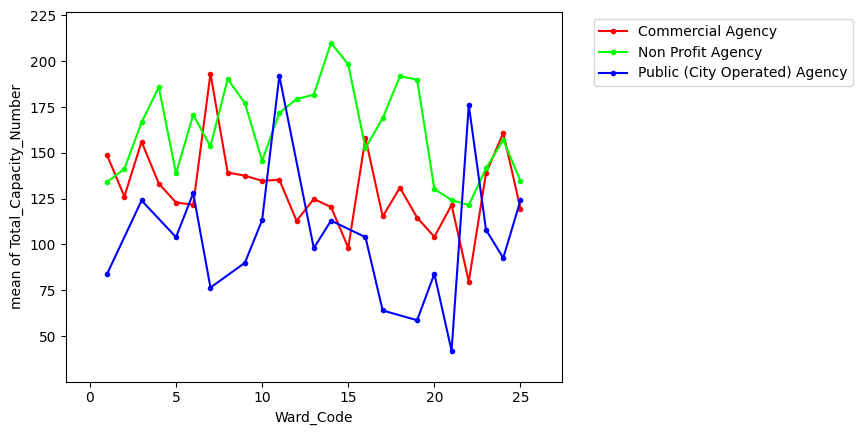

In [ ]:
# Plot the interaction plot
fig = interaction_plot(x=data["Ward_Code"], trace=data["Auspice_Type"], response=data["Total_Capacity_Number"])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
# Assumption 1: residuals are normally distributed: Shapiro Wilk test
# Perform Shapiro Wilk test
shapiro_test_auspice_ward_anova = shapiro(model_auspice_ward.resid)
st_auspice_ward_anova_p_value = shapiro_test_auspice_ward_anova.pvalue
# Round the p-value
st_auspice_ward_rounded_p_value = round_p_value(st_auspice_ward_anova_p_value)
print("Shapiro-Wilk test p-value:", st_auspice_ward_rounded_p_value)

Shapiro-Wilk test p-value: <0.001


In [30]:
# Assumption 2: variances are homogenous: Levene's test when the sample is not normally distributed

# Define a function to apply the levene test for two way anova
def levene_test_two_way_anova(df, factor1, factor2, response):
    # List to store results
    levene_results = []
    # Unique levels of the factors
    levels_factor1 = df[factor1].unique()
    levels_factor2 = df[factor2].unique()
    # Iterate over combinations of levels of the factors
    for level1 in levels_factor1:
        for level2 in levels_factor2:
            # Select data for the current combination of levels
            subset = df[(df[factor1] == level1) & (df[factor2] == level2)]
            # Perform Levene's test
            stat, p_value = levene(subset[response], subset.index)
            # Store the results
            levene_results.append([level1, level2, stat, p_value])
    # Create DataFrame from results
    levene_df = pd.DataFrame(levene_results, columns=[factor1, factor2, "Levene_statistic", "p_value"])
    return levene_df

# Perform Levene's test for the factors "Ward_Code" and "Auspice_Type"
levene_result_two_way = levene_test_two_way_anova(data, "Ward_Code", "Auspice_Type", "Total_Capacity_Number")
# Round the p-values
levene_result_two_way["p_value"] = levene_result_two_way["p_value"].apply(round_p_value)
# Display the results
levene_result_two_way

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:3189: RuntimeWarning: divide by zero encountered in scalar divide
  W = numer / denom
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:3189: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom


,Ward_Code,Auspice_Type,Levene_statistic,p_value
0,3,Non Profit Agency,16.746890,<0.001
1,3,Commercial Agency,18.226167,<0.001
2,3,Public (City Operated) Agency,inf,<0.001
3,8,Non Profit Agency,69.514777,<0.001
4,8,Commercial Agency,19.253394,<0.001
...,...,...,...,...
70,13,Commercial Agency,1.629972,0.238
71,13,Public (City Operated) Agency,inf,<0.001
72,16,Non Profit Agency,42.873742,<0.001
73,16,Commercial Agency,8.433752,0.00643


In [ ]:
# Because there are too many rows, filter the DataFrame to keep only rows where p-value is greater than 0.001
levene_result_two_way_filtered = levene_result_two_way[levene_result_two_way["p_value"] > 0.001]
# Display the filtered result
levene_result_two_way_filtered

,Ward_Code,Auspice_Type,Levene_statistic,p_value
7,25,Commercial Agency,1.633022,0.237
10,10,Commercial Agency,12.075580,0.002
11,10,Public (City Operated) Agency,1.187483,0.337
14,20,Public (City Operated) Agency,0.871256,0.403
16,24,Commercial Agency,2.619938,0.118
17,24,Public (City Operated) Agency,0.914374,0.393
19,6,Commercial Agency,5.308218,0.040
23,19,Public (City Operated) Agency,2.493817,0.189
24,4,Non Profit Agency,4.078977,0.048
25,4,Commercial Agency,6.980828,0.011
